In [1]:
# % matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

/home/luyao/miniconda3/envs/d2l/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/luyao/miniconda3/envs/d2l/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [3]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])

In [4]:
X = torch.rand(size=(1, 3, 256, 256))
net(X).shape

torch.Size([1, 512, 8, 8])

In [5]:
num_classes = 1
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                                    kernel_size=64, padding=16, stride=32))

In [6]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [7]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

In [8]:
img = torchvision.transforms.ToTensor()(plt.imread('images/train/image/0_0.tif'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

/home/luyao/miniconda3/envs/d2l/lib/python3.9/site-packages/torchvision/transforms/functional.py:150: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


input image shape: torch.Size([256, 256, 3])
output image shape: torch.Size([512, 512, 3])


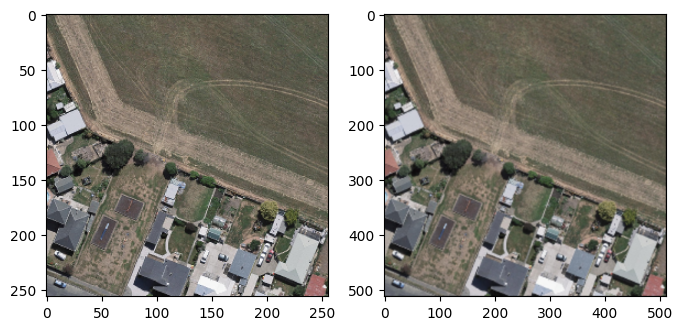

In [9]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
print('input image shape:', img.permute(1, 2, 0).shape)
print('output image shape:', out_img.shape)
plt.subplot(1, 2, 2)
plt.imshow(out_img)
plt.show()


In [10]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

In [3]:
import os

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, base_dir, transform=None, target_transform=None):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.fname_list = None
        self.base_dir = base_dir
        self.target_transform = target_transform
        self.create_fname_list()
        self.img_labels = self.fname_list

    def create_fname_list(self):
        self.fname_list = os.listdir(os.path.join(self.base_dir, 'image'))
        self.fname_list = list(filter(lambda x: x.find("tif") != -1, self.fname_list))

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # TODO: refactor
        img_path = os.path.join(self.base_dir, 'image', self.fname_list[idx])
        image = plt.imread(img_path)
        p2 = np.array(np.zeros((3, 256, 256)))
        p2[0, ...] = image[..., 0]
        p2[1, ...] = image[..., 1]
        p2[2, ...] = image[..., 2]
        label_path = os.path.join(self.base_dir, 'label', self.fname_list[idx])
        image_label = plt.imread(label_path)
        label = np.divide(image_label[..., 0], 255).astype(int)
        lab = np.array(np.zeros((1, 256, 256)))
        lab[0, :, :] = label
        tor = torch.from_numpy(p2)
        feature = self.normalize_image(tor)

        return feature, torch.from_numpy(lab).float()



In [4]:
from torch.utils.data import DataLoader

batch_size, crop_size = 13, (320, 480)
my_data_set_test = DataLoader(CustomImageDataset('images/test'), batch_size, num_workers=4)
my_data_set_train = DataLoader(CustomImageDataset('images/train'), batch_size, num_workers=4)

In [83]:
imga, imgb = next(my_data_set_train.__iter__())

imgb.shape

torch.Size([10, 1, 256, 256])

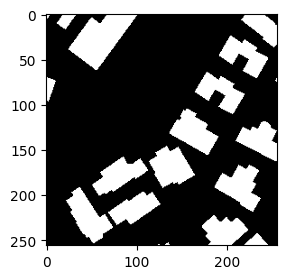

In [84]:
plt.figure(figsize=(3, 3))
plt.imshow(imgb[1][0], cmap="Greys_r")


In [5]:
# Create a neural net class
class Net(nn.Module):

    # Defining the Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()

        # In the init function, we define each layer we will use in our model

        # Our images are RGB, so we have input channels = 3.
        # We will apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)

        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)

        # We in the end apply max pooling with a kernel size of 2
        # self.pool = nn.MaxPool2d(kernel_size=2)

        # A drop layer deletes 20% of the features to help prevent overfitting
        # self.drop = nn.Dropout2d(p=0.2)

        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # This means that our feature tensors are now 32 x 32, and we've generated 24 of them

        # We need to flatten these in order to feed them to a fully-connected layer
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function

        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))

        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))

        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)

        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function
        return torch.log_softmax(x, dim=1)


device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=1).to(device)

print(model)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=24576, out_features=1, bias=True)
)


In [6]:
def get_model():
    model = torchvision.models.segmentation.fcn_resnet50(True)
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    model.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    return model

In [7]:
device = torch.device(f'cuda:{0}')
model = get_model()

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(),
                              lr=1e-4, weight_decay=1e-3)

/home/luyao/miniconda3/envs/d2l/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/home/luyao/miniconda3/envs/d2l/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2, -1)):
        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims

    def forward(self, x, y):
        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)

        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc

In [9]:
### Table for results
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'

In [10]:
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()
EPOCHES = 6


def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    # dice = dice_fn(y_pred.sigmoid(), y_true)
    # return 0.8 * bce + 0.2 * dice
    return bce

print(header)

for epoch in range(1, EPOCHES + 1):
    losses = []
    model.train()
    for image, target in my_data_set_train:
        image, target = image.to(device), target.float().to(device)
        optimizer.zero_grad()
        output = model(image)['out']
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    # vloss = validation(model, vloader, loss_fn)
    print(raw_line.format(epoch, np.array(losses).mean()))
    losses = []


        Train | Valid
Epoch |  Loss |  Loss | Time, m

     1│  0.293
     2│  0.154
     3│  0.104
     4│  0.082
     5│  0.069
     6│  0.061


In [11]:
ii, ll = next(my_data_set_train.__iter__())

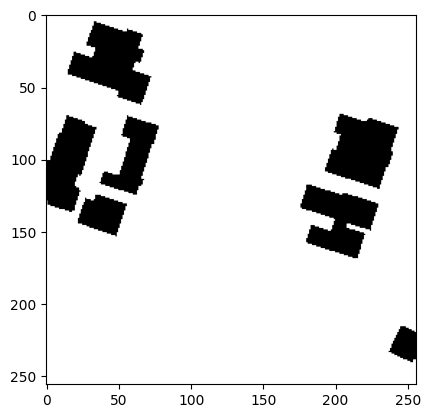

In [18]:
plt.imshow(ll[6][0], cmap="Greys")

In [19]:
ooo = output = model(ii.to(device))['out']

RuntimeError: CUDA out of memory. Tried to allocate 52.00 MiB (GPU 0; 5.79 GiB total capacity; 4.81 GiB already allocated; 26.75 MiB free; 4.87 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [14]:
narr = np.array(ooo.cpu().detach().numpy() )

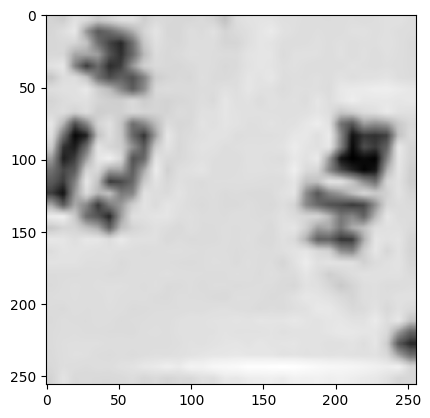

In [20]:
plt.imshow(narr[6][0], cmap="Greys")

In [65]:
ll.shape

torch.Size([10, 1, 256, 256])

In [30]:
loss_fn(ll[4][0][150], torch.tensor(narr[4][0][150]))

tensor(-0.5553)

In [31]:
ll[4][0][150]

tensor([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 

In [34]:
torch.tensor(narr[4][0][150])

tensor([ 0.3410,  0.3410,  0.3410,  0.3410,  0.1800, -0.1421, -0.4641, -0.7862,
        -1.1083, -1.4303, -1.7524, -2.0744, -2.4481, -2.8733, -3.2984, -3.7236,
        -4.1488, -4.5740, -4.9992, -5.4244, -5.5561, -5.3943, -5.2326, -5.0708,
        -4.9090, -4.7472, -4.5855, -4.4237, -4.3216, -4.2791, -4.2366, -4.1941,
        -4.1516, -4.1091, -4.0666, -4.0241, -4.0332, -4.0939, -4.1545, -4.2152,
        -4.2758, -4.3365, -4.3971, -4.4578, -4.4769, -4.4547, -4.4324, -4.4101,
        -4.3878, -4.3655, -4.3432, -4.3209, -4.3233, -4.3504, -4.3776, -4.4047,
        -4.4318, -4.4589, -4.4860, -4.5131, -4.5154, -4.4927, -4.4701, -4.4475,
        -4.4249, -4.4023, -4.3796, -4.3570, -4.3383, -4.3236, -4.3088, -4.2941,
        -4.2793, -4.2646, -4.2498, -4.2351, -4.2361, -4.2530, -4.2699, -4.2868,
        -4.3037, -4.3206, -4.3375, -4.3544, -4.3834, -4.4244, -4.4654, -4.5064,
        -4.5474, -4.5884, -4.6294, -4.6704, -4.6948, -4.7027, -4.7107, -4.7186,
        -4.7265, -4.7345, -4.7424, -4.75

In [26]:
narr[6][0]

array([[-3.5203555, -3.5203555, -3.5203555, ..., -4.5573897, -4.5573897,
        -4.5573897],
       [-3.5203555, -3.5203555, -3.5203555, ..., -4.5573897, -4.5573897,
        -4.5573897],
       [-3.5203555, -3.5203555, -3.5203555, ..., -4.5573897, -4.5573897,
        -4.5573897],
       ...,
       [-3.5027208, -3.5027208, -3.5027208, ..., -3.8803942, -3.8803942,
        -3.8803942],
       [-3.5027208, -3.5027208, -3.5027208, ..., -3.8803942, -3.8803942,
        -3.8803942],
       [-3.5027208, -3.5027208, -3.5027208, ..., -3.8803942, -3.8803942,
        -3.8803942]], dtype=float32)